I have identified mouse brain cell type-specific protein coding genes with pairwise dN/dS calculated from 92 mammalian species against human reference genome. Now I want to know which cell types have significantly higher dN/dS. This script calcuated these statistics. 

In [1]:
import numpy as np
import pandas as pd
import pingouin as pg
import glob
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows', 10)
from scipy import stats
import heapq

/opt/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.8, the latest is 0.3.9.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
celltype_list=['neuron','endothelia','glia','astrocyte','microglia','oligodendrocyte']

In [3]:
# load dN/dS data
df_dict={}
for celltype in celltype_list:
    df_dict[celltype]=pd.read_csv('../results/mouse.celltype-specific_genes/protein-coding_w_dNdS/all_92species/'
                                  +celltype+'.tsv',index_col=0, sep='\t')

In [4]:
df_dict['neuron']

,amelanoleuca_dNdS,anancymaae_dNdS,bbbison_dNdS,bmutus_dNdS,btaurus_dNdS,capalliatus_dNdS,caperea_dNdS,catys_dNdS,ccanadensis_dNdS,ccapucinus_dNdS,...,sscrofa_dNdS,tbelangeri_dNdS,tgelada_dNdS,ttruncatus_dNdS,uamericanus_dNdS,umaritimus_dNdS,uparryii_dNdS,vpacos_dNdS,vursinus_dNdS,vvulpes_dNdS
Gene name,,,,,,,,,,,,,,,,,,,,,
1500009L16Rik,NaN,0.146464,NaN,NaN,NaN,NaN,0.130144,0.120498,0.136314,0.140044,...,0.124107,NaN,0.122453,NaN,NaN,NaN,0.228487,NaN,0.156414,0.313078
1700001L19Rik,0.210556,0.185317,NaN,NaN,NaN,0.198950,0.122481,0.218690,NaN,0.160872,...,NaN,NaN,0.203604,NaN,0.258322,0.215824,0.150904,NaN,0.145022,0.110891
4930444P10Rik,NaN,0.409015,0.315946,0.326234,0.316695,0.348993,NaN,0.367046,0.290463,0.394530,...,0.284890,NaN,0.377320,NaN,0.442945,0.285058,0.333066,NaN,NaN,NaN
4930447C04Rik,0.306745,0.288215,0.290376,0.285083,NaN,0.302765,NaN,0.286950,0.357752,0.273928,...,0.285087,NaN,0.285519,0.281480,NaN,NaN,0.266246,NaN,0.346056,0.286567
4930452B06Rik,0.252119,0.210142,NaN,NaN,0.237885,0.255776,0.301566,0.266231,0.259158,0.225319,...,0.244310,NaN,0.235612,NaN,NaN,0.255673,0.205110,NaN,0.204127,0.228056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zim1,0.006937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.360649,NaN,...,NaN,NaN,NaN,NaN,0.041359,NaN,NaN,0.006681,0.135717,NaN
Zkscan16,NaN,0.351751,NaN,0.340327,NaN,0.355999,NaN,0.348691,0.331307,0.366090,...,0.293102,NaN,0.349349,0.341637,NaN,0.339294,0.374028,0.458960,NaN,0.356438
Zmat4,0.053008,0.032676,0.035883,0.035889,0.035482,0.041024,0.028862,0.053054,NaN,0.034377,...,0.044406,NaN,0.117155,NaN,NaN,0.051398,0.040253,NaN,0.093579,0.051676


# All species cell type-specific genes' pairwise dN/dS against mouse genome pooled together without averaging

In [4]:
# pool dN/dS from 92 species into 1D array
arr_dict={}
for celltype in celltype_list:
    arr=df_dict[celltype].to_numpy()
    arr=arr[~np.isnan(arr)]
    arr_dict[celltype]=arr
    arr_dict[celltype].shape

(86260,)

(61687,)

(80131,)

(56301,)

(68157,)

(35624,)

In [6]:
# Mann Whitney U test between neuron and each non-neuronal celltype
for celltype in ['endothelia','glia','astrocyte','microglia','oligodendrocyte']:
    celltype
    stats.mannwhitneyu(arr_dict['neuron'],arr_dict[celltype],alternative="two-sided")

'endothelia'

MannwhitneyuResult(statistic=1843208704.5, pvalue=0.0)

'glia'

MannwhitneyuResult(statistic=2401686399.0, pvalue=0.0)

'astrocyte'

MannwhitneyuResult(statistic=1933844695.0, pvalue=0.0)

'microglia'

MannwhitneyuResult(statistic=1882912853.0, pvalue=0.0)

'oligodendrocyte'

MannwhitneyuResult(statistic=1348618487.0, pvalue=7.702811370580747e-248)

The p values were lower than the smallest number representable with numpy float numbers, so there were simply written as 0.0

In [59]:
np.finfo('float').tiny

2.2250738585072014e-308

Our array had a large number of data:

In [62]:
arr_dict['glia'].shape

(80131,)

While with just a couple hundred data it is possible to reach such a low p value with Mann Whitney U test: 

In [73]:
stats.mannwhitneyu(np.full((700,),0),np.full((700,),0.1),alternative="two-sided")

MannwhitneyuResult(statistic=0.0, pvalue=3.475138136748824e-306)

In [7]:
# Kruskal Wallis H test for neuron, endothelia, glia three cell types
stats.kruskal(arr_dict['neuron'],arr_dict['endothelia'],arr_dict['glia'])

KruskalResult(statistic=15068.010565252689, pvalue=0.0)

In [8]:
# Kruskal Wallis H test for NEAMO five cell types
stats.kruskal(arr_dict['neuron'],arr_dict['endothelia'],arr_dict['astrocyte'],arr_dict['microglia'],arr_dict['oligodendrocyte'])

KruskalResult(statistic=19080.63760123451, pvalue=0.0)

In [9]:
stats_df = pd.DataFrame(
    columns=['Celltype','Median_dNdS',
             'Confidence_Interval_Low','Confidence_Interval_High'])

for celltype in celltype_list:
    arr=arr_dict[celltype]
    med=np.median(arr)
    low = stats.binom.interval(alpha=.95,n=arr.shape[0],p=.5)[0]
    high = stats.binom.interval(alpha=.95,n=arr.shape[0],p=.5)[1]
    CI_low = heapq.nsmallest(low.astype(int),arr)[-1]
    CI_high = heapq.nsmallest(high.astype(int),arr)[-1]
    stats_df = stats_df.append(
        {'Celltype':celltype,'Median_dNdS':med,
         'Confidence_Interval_Low':CI_low,'Confidence_Interval_High':CI_high},
        ignore_index=True)

stats_df.set_index('Celltype',inplace=True)
    
stats_df

,Median_dNdS,Confidence_Interval_Low,Confidence_Interval_High
Celltype,,,
neuron,0.070163,0.069543,0.070742
endothelia,0.118995,0.118036,0.119894
glia,0.120077,0.119231,0.120914
astrocyte,0.103976,0.102941,0.104970
microglia,0.131917,0.130960,0.132936
oligodendrocyte,0.088088,0.087188,0.089008


# Now one species at a time

In [6]:
# add average of 92 species as a "species"
# so statistical analysis looped through "species" 
# would also be calculated on the averaged value
for celltype in celltype_list:
    df=df_dict[celltype]
    df['average_dNdS']=df.mean(axis=1)

In [7]:
# Get a list of species name (including 'average' at the end of the list)
species_list=[]
for species in df_dict['neuron'].columns:
    species_list.append(species[:-5])

In [8]:
# Find the rare cases where neuron-specific genes don't have the lowest dN/dS
for species in species_list:
    if np.median(df_dict['neuron'][[species+'_dNdS']].iloc[:,0].dropna().values) > np.median(df_dict['oligodendrocyte'][[species+'_dNdS']].iloc[:,0].dropna().values):
        print(species) # Hedgehog 


eeuropaeus


##### Descriptive Statistics: median and confidence interval

In [9]:
full_dict = {} # This dictionary stores dataframes for later use 
descriptive_stats_df = pd.DataFrame(
    columns=['Species','Celltype','Median_dNdS',
             'Confidence_Interval_Low','Confidence_Interval_High',
             'Median_Absolute_Deviation'])
for species in species_list:
    full_dict[species] = {}
    for celltype in celltype_list:
        df=df_dict[celltype][[species+'_dNdS']]
        full_dict[species][celltype]=df.dropna().values
        arr=df.iloc[:,0].dropna().values
        med=np.median(arr)
        mad=pg.mad(arr,normalize=False)
        low = stats.binom.interval(alpha=.95,n=arr.shape[0],p=.5)[0]
        high = stats.binom.interval(alpha=.95,n=arr.shape[0],p=.5)[1]
        CI_low = heapq.nsmallest(low.astype(int),arr)[-1]
        CI_high = heapq.nsmallest(high.astype(int),arr)[-1]
        descriptive_stats_df = descriptive_stats_df.append(
            {'Species':species,'Celltype':celltype,'Median_dNdS':med,
             'Confidence_Interval_Low':CI_low,'Confidence_Interval_High':CI_high,
            'Median_Absolute_Deviation':mad},
            ignore_index=True)

In [10]:
common_name_df=pd.read_excel('../data/species.xlsx',index_col=0)
common_name_df=common_name_df.append(pd.Series(['average','average','average'],name='average',index=common_name_df.columns))

In [15]:
descriptive_stats_df=pd.merge(left=common_name_df,right=descriptive_stats_df,left_index=True,right_on='Species',how='right')
descriptive_stats_df.set_index('SpeciesCommonName',inplace=True)
descriptive_stats_df.drop(['SpeciesLatinName','Order','Species'],axis=1,inplace=True)

In [16]:
descriptive_stats_df.loc['average',:]

,Celltype,Median_dNdS,Confidence_Interval_Low,Confidence_Interval_High,Median_Absolute_Deviation
SpeciesCommonName,,,,,
average,neuron,0.073001,0.068361,0.076786,0.039584
average,endothelia,0.125274,0.117180,0.135850,0.066218
average,glia,0.127601,0.121065,0.134291,0.067144
average,astrocyte,0.110885,0.101351,0.117072,0.059529
average,microglia,0.142691,0.134883,0.152953,0.080206
average,oligodendrocyte,0.087372,0.081122,0.097106,0.044336


In [19]:
# create an excel file to write descriptive stats

path = '../results/celltype-specific_descriptive_stats.xlsx'
writer = pd.ExcelWriter(path, engine = 'xlsxwriter')

descriptive_stats_df.to_excel(writer, sheet_name = 'mouse reference genome',index=True)

writer.save()
writer.close()


In [47]:
# # if I want to add tab to existing excel file

# from openpyxl import load_workbook

# path = '../results/celltype-specific_descriptive_stats.xlsx'
# book = load_workbook(path)
# writer = pd.ExcelWriter(path, engine = 'openpyxl') # note the engine
# # writer = pd.ExcelWriter(path, engine = 'xlsxwriter') # use this engine if creating a new file
# writer.book = book

# descriptive_stats_df.to_excel(writer, sheet_name = 'mouse reference genome',index=True)

# writer.save()
# writer.close()

### Inferential statistics: Kruskal Wallis H and Mann Whitney U between celltypes and benchmarks

In [62]:
# create a dictionary to store average dN/dS of benchmark genes
bm_dict={}

# import from excel file work sheets 
hk_df = pd.read_excel('../data/benchmarks.xlsx',sheet_name='House Keeping Genes',index_col=0)
bm_dict['hk']=hk_df.dropna().values
mhc_df = pd.read_excel('../data/benchmarks.xlsx',sheet_name='MHC',index_col=0)
bm_dict['mhc']=mhc_df.dropna().values
atpase_df = pd.read_excel('../data/benchmarks.xlsx',sheet_name='ATPase',index_col=0)
bm_dict['atpase']=atpase_df.dropna().values
immune_df = pd.read_excel('../data/benchmarks.xlsx',sheet_name='Immune System Genes',index_col=0)
bm_dict['immune']=immune_df.dropna().values

# import all genes' dN/dS
all_df = pd.read_csv('../results/Ensembl98_mouse/mouse.dNdS_stats.all_genes.tsv',sep='\t')
all_arr=all_df.loc[:,'mean'].dropna().values
bm_dict['all']=all_arr.reshape((len(all_arr),1))


In [63]:
for value in bm_dict.values():
    value.shape

(3265, 1)

(26, 1)

(116, 1)

(683, 1)

(19388, 1)

In [64]:
# descriptive stats of benchmarks
bm_stats_df = pd.DataFrame(
    columns=['Benchmark','Median_dNdS',
             'Confidence_Interval_Low','Confidence_Interval_High'])

for key, arr in bm_dict.items():
    med=np.median(arr)
    low = stats.binom.interval(alpha=.95,n=arr.shape[0],p=.5)[0]
    high = stats.binom.interval(alpha=.95,n=arr.shape[0],p=.5)[1]
    CI_low = heapq.nsmallest(low.astype(int),arr)[-1]
    CI_high = heapq.nsmallest(high.astype(int),arr)[-1]
    bm_stats_df = bm_stats_df.append(
        {'Benchmark':key,'Median_dNdS':med,
         'Confidence_Interval_Low':CI_low,'Confidence_Interval_High':CI_high},
        ignore_index=True)

bm_stats_df.set_index('Benchmark',inplace=True)
    
bm_stats_df

,Median_dNdS,Confidence_Interval_Low,Confidence_Interval_High
Benchmark,,,
hk,0.086212,[0.0833990353536832],[0.089668482209337]
mhc,0.442520,[0.336932240967922],[0.511041009463722]
atpase,0.066155,[0.0558833038513241],[0.0806013091323478]
immune,0.143419,[0.128522782808735],[0.159698081571992]
all,0.129408,[0.12735527061240987],[0.13149618323475998]


In [69]:
np.median(full_dict['average']['microglia'])

0.1426914760460037

In [49]:
bm_dict['immune'].shape
full_dict['average']['microglia'].shape

(683,)

(1062, 1)

immune system processing genes have a slightly higher median dN/dS than microglia-specific genes. Interestingly, from a ranking perspective, microglia is slightly higher (not significant) than immune system processing: 

In [71]:
pg.mwu(bm_dict['immune'],full_dict['average']['microglia'],tail="one-sided")

,U-val,tail,p-val,RBC,CLES
MWU,359076.0,greater,0.6369,0.009918,0.495041


In [70]:
pg.mwu(full_dict['average']['microglia'],bm_dict['immune'],tail="one-sided")

,U-val,tail,p-val,RBC,CLES
MWU,366270.0,less,0.6369,-0.009918,0.495041


In [16]:
full_dict['average']['glia']

array([[0.45306513],
       [0.73359041],
       [0.29008031],
       ...,
       [0.13371906],
       [0.09212271],
       [0.06421655]])

In [11]:
full_dict['average']['glia'].shape
full_dict['average']['neuron'].shape

(1211, 1)

(1298, 1)

pingouin and scipy.stats calculate U statistics in the same way. If you are testing if glia is higher than neuron, then you need to list glia before neruon: 

In [12]:
stats.mannwhitneyu(full_dict[species]['neuron'],
        full_dict[species]['glia'],alternative="two-sided")

MannwhitneyuResult(statistic=536949.0, pvalue=6.554592649494534e-43)

In [13]:
pg.mwu(
        full_dict[species]['neuron'],
        full_dict[species]['glia'],
        tail="two-sided").iloc[0,:]

U-val         536949
tail       two-sided
p-val    6.55459e-43
RBC         0.316806
CLES        0.341597
Name: MWU, dtype: object

In [14]:
stats.mannwhitneyu(full_dict[species]['glia'],
        full_dict[species]['neuron'],alternative="two-sided")

MannwhitneyuResult(statistic=1034929.0, pvalue=6.554592649494534e-43)

In [15]:
pg.mwu(
        full_dict[species]['glia'],
        full_dict[species]['neuron'],
        tail="two-sided").iloc[0,:]

U-val    1.03493e+06
tail       two-sided
p-val    6.55459e-43
RBC        -0.316806
CLES        0.658403
Name: MWU, dtype: object

In [73]:
inferential_stats_df=pd.DataFrame(
    columns=['Species','Kruskal H NEG','Kruskal p NEG',
             'Kruskal H NEAMO','Kruskal p NEAMO',
             'Mann U GN','Mann p GN','Mann CLES GN',
             'Mann U EN','Mann p EN','Mann CLES EN',
             'Mann U GE','Mann p GE','Mann CLES GE',
             'Mann U AN','Mann p AN','Mann CLES AN',
             'Mann U MN','Mann p MN','Mann CLES MN',
             'Mann U ON','Mann p ON','Mann CLES ON'])

for species in species_list:

    h_NEG,kp_NEG=stats.kruskal(
        full_dict[species]['neuron'],
        full_dict[species]['endothelia'],
        full_dict[species]['glia'])

    h_NEAMO,kp_NEAMO=stats.kruskal(
        full_dict[species]['neuron'],
        full_dict[species]['endothelia'],
        full_dict[species]['astrocyte'],
        full_dict[species]['microglia'],
        full_dict[species]['oligodendrocyte'])
    
    # June 18, 2020: debug on Jan_20_2020-Confirming_w_Couple_Species-Ensembl98Mouse
    # June 24, 2020: debug stats.mannwhitneyu(), include alternative="two-sided", 
    # default "None" is deprecated and generate a smaller p value
    # Now avoid nan values influencing test results.
    # U statistics and p values from Mann Whitney's U test 
    # comparing Neuron-specific genes and Glia-specific genes' dN/dS ratios
    # Dec 7, 2020: Use pingouin instead of scipy, now have common language effect size
    
    u_GN,_,mp_GN,_,cles_GN=pg.mwu(
        full_dict[species]['glia'],
        full_dict[species]['neuron'],
        tail="two-sided").iloc[0,:]
    
    # similarly, compare neuron-specific genes and endothelia-specific genes
    u_EN,_,mp_EN,_,cles_EN=pg.mwu(
        full_dict[species]['endothelia'],
        full_dict[species]['neuron'],
        tail="two-sided").iloc[0,:]
    
    # and endothelia vs glia
    u_GE,_,mp_GE,_,cles_GE=pg.mwu(
        full_dict[species]['glia'],
        full_dict[species]['endothelia'],
        tail="two-sided").iloc[0,:]
    
    # and neuron vs the three glial subtypes
    u_AN,_,mp_AN,_,cles_AN=pg.mwu(
        full_dict[species]['astrocyte'],
        full_dict[species]['neuron'],
        tail="two-sided").iloc[0,:]
    
    u_MN,_,mp_MN,_,cles_MN=pg.mwu(
        full_dict[species]['microglia'],
        full_dict[species]['neuron'],
        tail="two-sided").iloc[0,:]
    
    u_ON,_,mp_ON,_,cles_ON=pg.mwu(
        full_dict[species]['oligodendrocyte'],
        full_dict[species]['neuron'],
        tail="two-sided").iloc[0,:]
    
    inferential_stats_df = inferential_stats_df.append(
            {'Species':species,'Kruskal H NEG':h_NEG,'Kruskal p NEG':kp_NEG,
            'Kruskal H NEAMO':h_NEAMO,'Kruskal p NEAMO':kp_NEAMO,
            'Mann U GN':u_GN,'Mann p GN':mp_GN,'Mann CLES GN':cles_GN,
            'Mann U EN':u_EN,'Mann p EN':mp_EN,'Mann CLES EN':cles_EN,
            'Mann U GE':u_GE,'Mann p GE':mp_GE,'Mann CLES GE':cles_GE,
            'Mann U AN':u_AN,'Mann p AN':mp_AN,'Mann CLES AN':cles_AN,
            'Mann U MN':u_MN,'Mann p MN':mp_MN,'Mann CLES MN':cles_MN,
            'Mann U ON':u_ON,'Mann p ON':mp_ON,'Mann CLES ON':cles_ON},
            ignore_index=True)

inferential_stats_df=pd.merge(left=common_name_df,right=inferential_stats_df,left_index=True,right_on='Species',how='right')
inferential_stats_df.set_index('SpeciesCommonName',inplace=True)
inferential_stats_df.drop(['SpeciesLatinName','Order','Species'],axis=1,inplace=True)

In [74]:
inferential_stats_df

,Kruskal H NEG,Kruskal p NEG,Kruskal H NEAMO,Kruskal p NEAMO,Mann U GN,Mann p GN,Mann CLES GN,Mann U EN,Mann p EN,Mann CLES EN,...,Mann CLES GE,Mann U AN,Mann p AN,Mann CLES AN,Mann U MN,Mann p MN,Mann CLES MN,Mann U ON,Mann p ON,Mann CLES ON
SpeciesCommonName,,,,,,,,,,,,,,,,,,,,,
Panda,210.041102,2.455580e-46,247.194656,2.617407e-52,672529.0,2.545612e-37,0.664423,525765.0,2.263768e-32,0.663217,...,0.497284,426394.0,2.705061e-14,0.608830,588307.0,1.447538e-41,0.681621,257265.0,0.000122,0.563251
Ma's night monkey,231.025530,6.814649e-51,289.788044,1.727282e-61,716195.0,1.297535e-36,0.659999,558395.0,1.773999e-39,0.679933,...,0.481631,471727.0,6.711266e-15,0.608476,621387.0,2.173369e-47,0.692890,271503.0,0.000019,0.569995
American bison,156.872780,8.620027e-35,191.462284,2.570749e-40,443633.0,1.974700e-28,0.657602,350038.0,6.436258e-25,0.656524,...,0.498561,291953.0,3.790698e-12,0.608741,404161.0,2.324427e-34,0.680097,174890.0,0.000021,0.577206
Wild yak,156.987769,8.138400e-35,200.750491,2.591293e-42,488638.0,1.349891e-29,0.657125,388288.0,1.048678e-23,0.647924,...,0.505908,325898.0,7.797933e-13,0.609110,439819.0,1.034526e-35,0.679992,184025.0,0.001595,0.556168
Cow,198.450180,8.074041e-44,259.249882,6.616519e-55,676463.0,6.005384e-35,0.658279,532333.0,5.492733e-31,0.658805,...,0.498598,439432.0,4.211320e-14,0.607106,605994.0,2.415733e-46,0.691575,265018.0,0.000051,0.566309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Arctic ground squirrel,248.258430,1.234147e-54,313.693014,1.204100e-66,747128.0,2.103225e-42,0.671661,574206.0,2.410950e-39,0.678022,...,0.492211,483960.0,5.630397e-17,0.616155,658822.0,4.643431e-54,0.704064,280902.0,0.000014,0.570298
Alpaca,37.164058,8.509958e-09,53.885406,5.561619e-11,19772.0,3.451595e-07,0.658408,19903.0,8.378094e-08,0.666812,...,0.492387,18634.0,1.946911e-03,0.595259,16203.0,9.605730e-11,0.717963,7237.0,0.001928,0.631170
Common wombat,113.226073,2.589827e-25,125.245555,4.044696e-26,498907.0,8.993294e-19,0.620763,403139.0,3.091230e-20,0.634315,...,0.487969,350182.0,7.370548e-10,0.591674,435467.0,9.171326e-21,0.633130,220262.0,0.000005,0.578191


In [75]:
# Create and write to excel file for inferential stats

# path = '../results/celltype-specific_inferential_stats.xlsx'
# writer = pd.ExcelWriter(path, engine = 'xlsxwriter')

# inferential_stats_df.to_excel(writer, sheet_name = 'mouse reference genome', index=True) #July 17th, 2020: minor bug fix: include species name as index

# writer.save()
# writer.close()

# # if I want to add tab to existing excel file

from openpyxl import load_workbook

path = '../results/celltype-specific_inferential_stats.xlsx'
book = load_workbook(path)
writer = pd.ExcelWriter(path, engine = 'openpyxl') # note the engine
# writer = pd.ExcelWriter(path, engine = 'xlsxwriter') # use this engine if creating a new file
writer.book = book

inferential_stats_df.to_excel(writer, sheet_name = 'mouse reference genome',index=True)

writer.save()
writer.close()

### Mann-Whitney U test of average dN/dS: cell types against Endothelial cell

In [76]:
pg.mwu(
        full_dict['average']['oligodendrocyte'],
        full_dict['species']['endothelia'],
        tail="one-sided"
)

,U-val,tail,p-val,RBC,CLES
MWU,183234.0,less,1.407527e-15,0.249313,0.624657


In [83]:
pg.mwu(
        full_dict['average']['astrocyte'],
        full_dict['average']['endothelia'],
        tail="one-sided"
)

,U-val,tail,p-val,RBC,CLES
MWU,336205.0,less,0.000001,0.129102,0.564551


In [85]:
pg.mwu(
        full_dict['average']['astrocyte'],
        full_dict['average']['endothelia'],
        tail="one-sided"
).iloc[0,2]

1.428852114698087e-06

In [86]:
pg.mwu(
        full_dict['average']['microglia'],
        full_dict['average']['endothelia'],
        tail="one-sided"
)

,U-val,tail,p-val,RBC,CLES
MWU,536985.0,greater,0.001098,-0.079265,0.539632


In [108]:
full_dict['average']['microglia'].shape
full_dict['average']['endothelia'].shape

(1062, 1)

(937, 1)

In [87]:
pg.mwu(
        full_dict['average']['microglia'],
        full_dict['average']['endothelia'],
        tail="one-sided"
).iloc[0,2]

0.001098081113106067

### Mann-Whitney U test of average dN/dS: benchmarks against Neuron and Endothelial cell

In [94]:
pd.set_option("precision",9) # display 9 decimal places

In [95]:
for key, arr in bm_dict.items():
    print(key)
    pg.mwu(
            arr,
            full_dict['average']['neuron'],
            tail="one-sided"
    )
    pg.mwu(
            arr,
            full_dict['average']['endothelia'],
            tail="one-sided"
    )

hk


,U-val,tail,p-val,RBC,CLES
MWU,2255229.0,greater,0.000344961,-0.064296821,0.532148411


,U-val,tail,p-val,RBC,CLES
MWU,1101316.0,less,1.997554498e-39,0.280022097,0.640011048


mhc


,U-val,tail,p-val,RBC,CLES
MWU,32131.0,greater,1.357060916e-15,-0.904172099,0.95208605


,U-val,tail,p-val,RBC,CLES
MWU,21617.0,greater,7.668883799e-12,-0.774649044,0.887324522


atpase


,U-val,tail,p-val,RBC,CLES
MWU,68651.0,less,0.057735936,0.088106371,0.544053185


,U-val,tail,p-val,RBC,CLES
MWU,32290.5,less,4.733773022e-13,0.405834836,0.702917418


immune


,U-val,tail,p-val,RBC,CLES
MWU,594815.0,greater,2.762316472e-36,-0.341888749,0.670944374


,U-val,tail,p-val,RBC,CLES
MWU,340233.0,greater,0.014717626,-0.063276305,0.531638152


all


,U-val,tail,p-val,RBC,CLES
MWU,16437417.5,greater,9.197033849e-77,-0.306338957,0.653169478


,U-val,tail,p-val,RBC,CLES
MWU,9054469.0,greater,0.565226682,0.003171652,0.498414174


In [96]:
pg.mwu(
        bm_dict['atpase'],
        full_dict['average']['neuron'],
        tail="one-sided"
)
pg.mwu(
        bm_dict['atpase'],
        full_dict['average']['endothelia'],
        tail="one-sided"
)

,U-val,tail,p-val,RBC,CLES
MWU,68651.0,less,0.057735936,0.088106371,0.544053185


,U-val,tail,p-val,RBC,CLES
MWU,32290.5,less,4.733773022e-13,0.405834836,0.702917418


# Visualization

In [ ]:
# import statsmodels.api as sm
# import matplotlib.ticker as mtick

In [22]:
import matplotlib
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
import seaborn as sns
matplotlib.rcParams['figure.dpi']= 300
from copy import deepcopy

In [23]:
graph_dict = deepcopy(full_dict)
graph_df = pd.DataFrame(columns=['dNdS','Species','Celltype'])
for celltype in celltype_list:
    for species in species_list:
        graph_dict[species][celltype]=pd.DataFrame(graph_dict[species][celltype],columns=['dNdS'])
        graph_dict[species][celltype]=graph_dict[species][celltype].assign(Species=species)
        graph_dict[species][celltype]=graph_dict[species][celltype].assign(Celltype=celltype)
        graph_df=graph_df.append(graph_dict[species][celltype][['dNdS','Species','Celltype']],ignore_index=True)
graph_df=pd.merge(common_name_df,graph_df,left_index=True,right_on='Species',how='right')
graph_df.set_index('SpeciesCommonName',inplace=True)
graph_df.drop(['SpeciesLatinName','Order','Species'],axis=1,inplace=True)

In [24]:
graph_df

,dNdS,Celltype
SpeciesCommonName,,
Panda,0.210556,neuron
Panda,0.306745,neuron
Panda,0.252119,neuron
Panda,0.380407,neuron
Panda,0.131689,neuron
...,...,...
average,0.077988,oligodendrocyte
average,0.052152,oligodendrocyte
average,0.036849,oligodendrocyte


In [25]:
# get a list of species common names
species_common_list=common_name_df['SpeciesCommonName'].to_list()
species_common_list.remove('Mouse')

In [26]:
sns.set_style('ticks')

In [27]:
palette={'endothelia':'tab:blue','glia':'tab:green','neuron':'tab:red','oligodendrocyte':'lightblue','astrocyte':'lightgreen','microglia':'tab:orange'}

In [97]:
for species in species_common_list:
    data=graph_df.loc[species,:]
    fig = plt.figure(figsize=(10,7.5))
    ax = fig.add_subplot(111)
    ax = sns.boxplot(y="dNdS", x="Celltype", data=data,showfliers=False,palette=palette)
    ax.set_yscale('log')
    _=ax.set_ylim(0.0005,1)
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    sns.despine()
    stats = add_stat_annotation(ax=ax,data=data,x="Celltype", y="dNdS",
                        box_pairs=[("endothelia", "neuron"),
                                   ("endothelia", "glia"),
                                   ("glia","neuron"),
                                   ("astrocyte","neuron"),
                                   ("microglia","neuron"),
                                   ("oligodendrocyte","neuron"),
                                   ("astrocyte","microglia"),
                                   ("microglia","oligodendrocyte"),
                                   ("astrocyte","oligodendrocyte")],
                        test='Mann-Whitney', text_format='star',
                        loc='outside', verbose=0)
    pd.DataFrame(stats[1]).to_csv('../results/mouse.celltype-specific_genes/protein-coding_w_dNdS/MannWhitney/'+species+'.tsv',sep='\t',index=False)
#     ax.set_xlabel("Cell Types")
    _=ax.set_ylabel("dN/dS of Cell Type-specific Genes")
    plt.savefig('../figures/MannWhitney/mouse_reference_genome/'+species+'.pdf')
    plt.close()

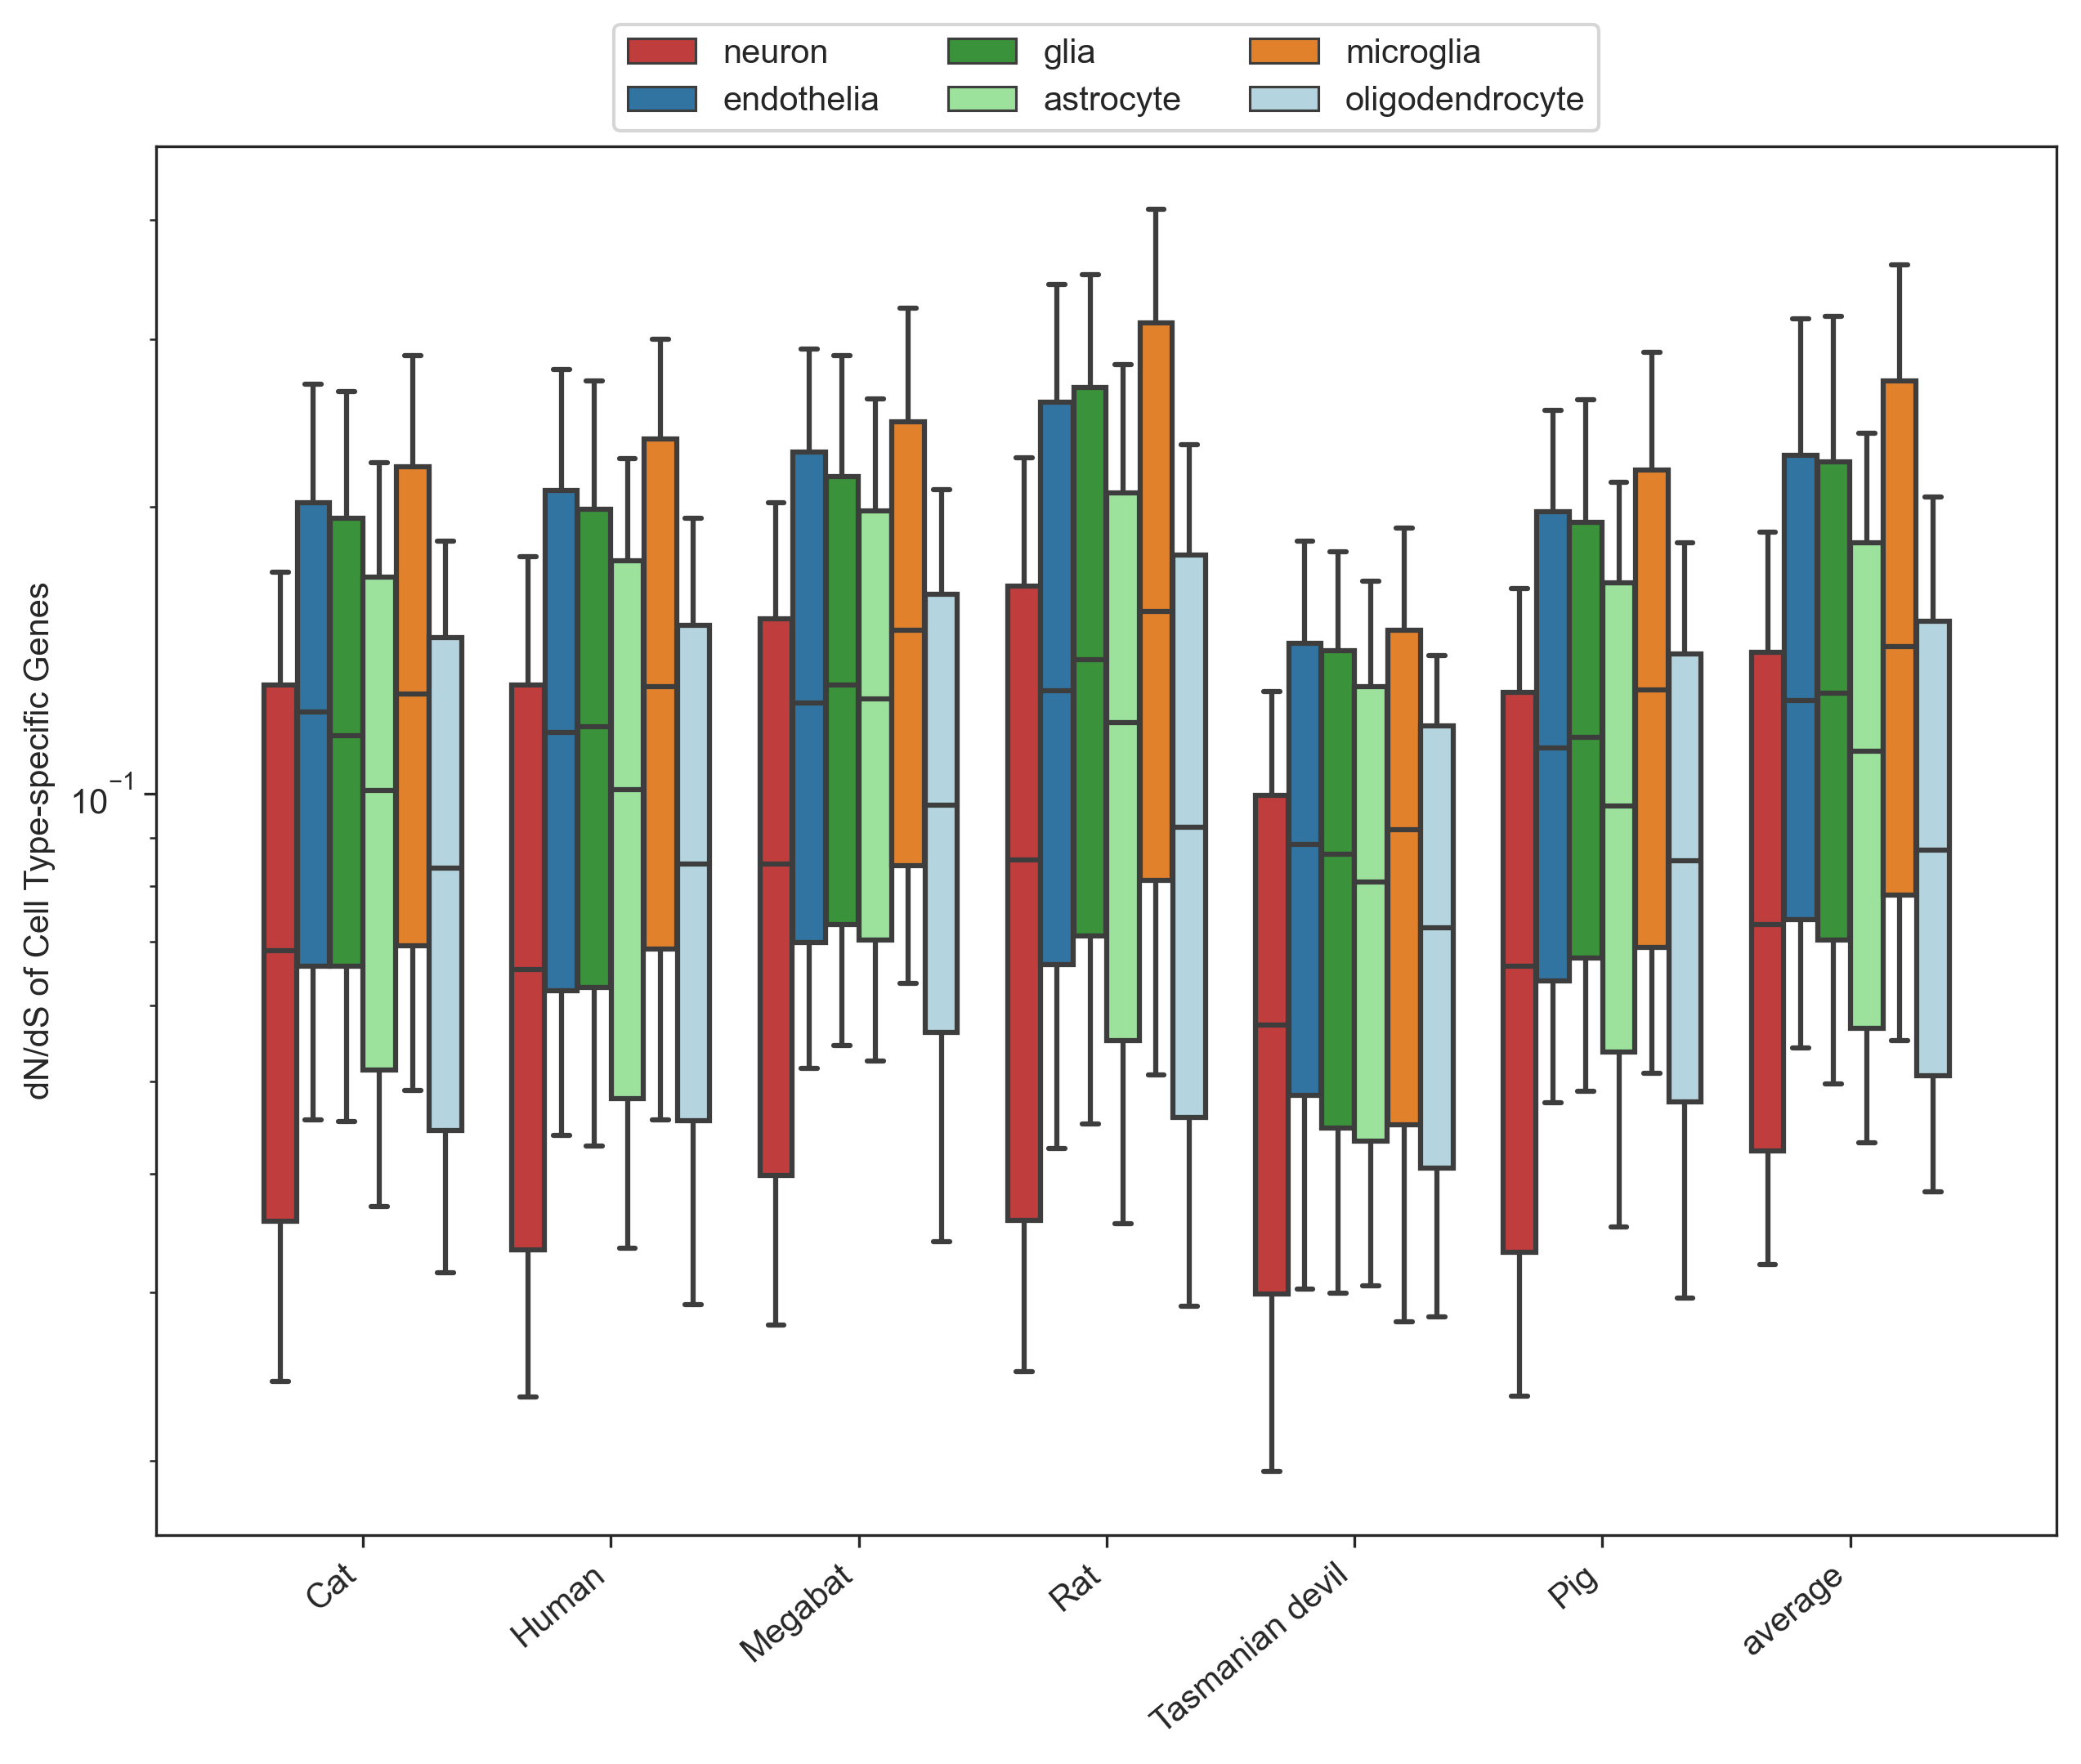

In [70]:
# Figure with some representitive species
data=graph_df[graph_df['dNdS']!=0].reset_index()
data=data[data['SpeciesCommonName'].isin(['Human','Rat','Opposum','Megabat','Tasmanian devil','Cat','Pig','average'])]
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot()
# flierprops = dict(marker='o',markerfacecolor='1', markersize=2,linestyle='none')
whis=[15, 85]
ax = sns.boxplot(x="SpeciesCommonName", y="dNdS", hue="Celltype", data=data, palette=palette, whis=whis, showfliers=False)
_=ax.set(yscale='log')
_=ax.set_ylim(0.0005,1)
_=ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
_=ax.legend(loc='upper center', bbox_to_anchor=(0.5,1.1),ncol=3)
_=ax.set_xlabel("")
_=ax.set_ylabel("dN/dS of Cell Type-specific Genes")
plt.autoscale()
# plt.savefig('../figures/mouse.boxplots.pdf')
plt.show()

In [21]:
# n_df=pd.DataFrame()
# n_df['dNdS']=pd.Series(n_array)
# n_df['celltype']='Neuron'
# e_df=pd.DataFrame()
# e_df['dNdS']=pd.Series(e_array)
# e_df['celltype']='Endothelial Cell'
# g_df=pd.DataFrame()
# g_df['dNdS']=pd.Series(g_array)
# g_df['celltype']='Glial Cell'
# df=pd.concat([e_df,g_df,n_df])

In [30]:
data

,SpeciesCommonName,dNdS,Celltype
0,Panda,0.210556,neuron
1,Panda,0.306745,neuron
2,Panda,0.252119,neuron
3,Panda,0.380407,neuron
4,Panda,0.131689,neuron
...,...,...,...
230307,Red fox,0.059611,glia
230308,Red fox,0.206826,glia
230309,Red fox,0.302362,glia
230310,Red fox,0.094507,glia


[None]

(0.0008, 6)

[Text(0, 0.5, 'all pairwise dN/dS scores'), Text(0.5, 0, '')]

p-value annotation legend:
ns: 1.00e-04 < p <= 1.00e+00
*: 1.00e-05 < p <= 1.00e-04
**: 1.00e-06 < p <= 1.00e-05
***: 1.00e-07 < p <= 1.00e-06
****: p <= 1.00e-07

endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided, P_val=3.340e-01 U_stat=2.479e+09
glia v.s. neuron: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=4.510e+09
endothelia v.s. neuron: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=3.478e+09


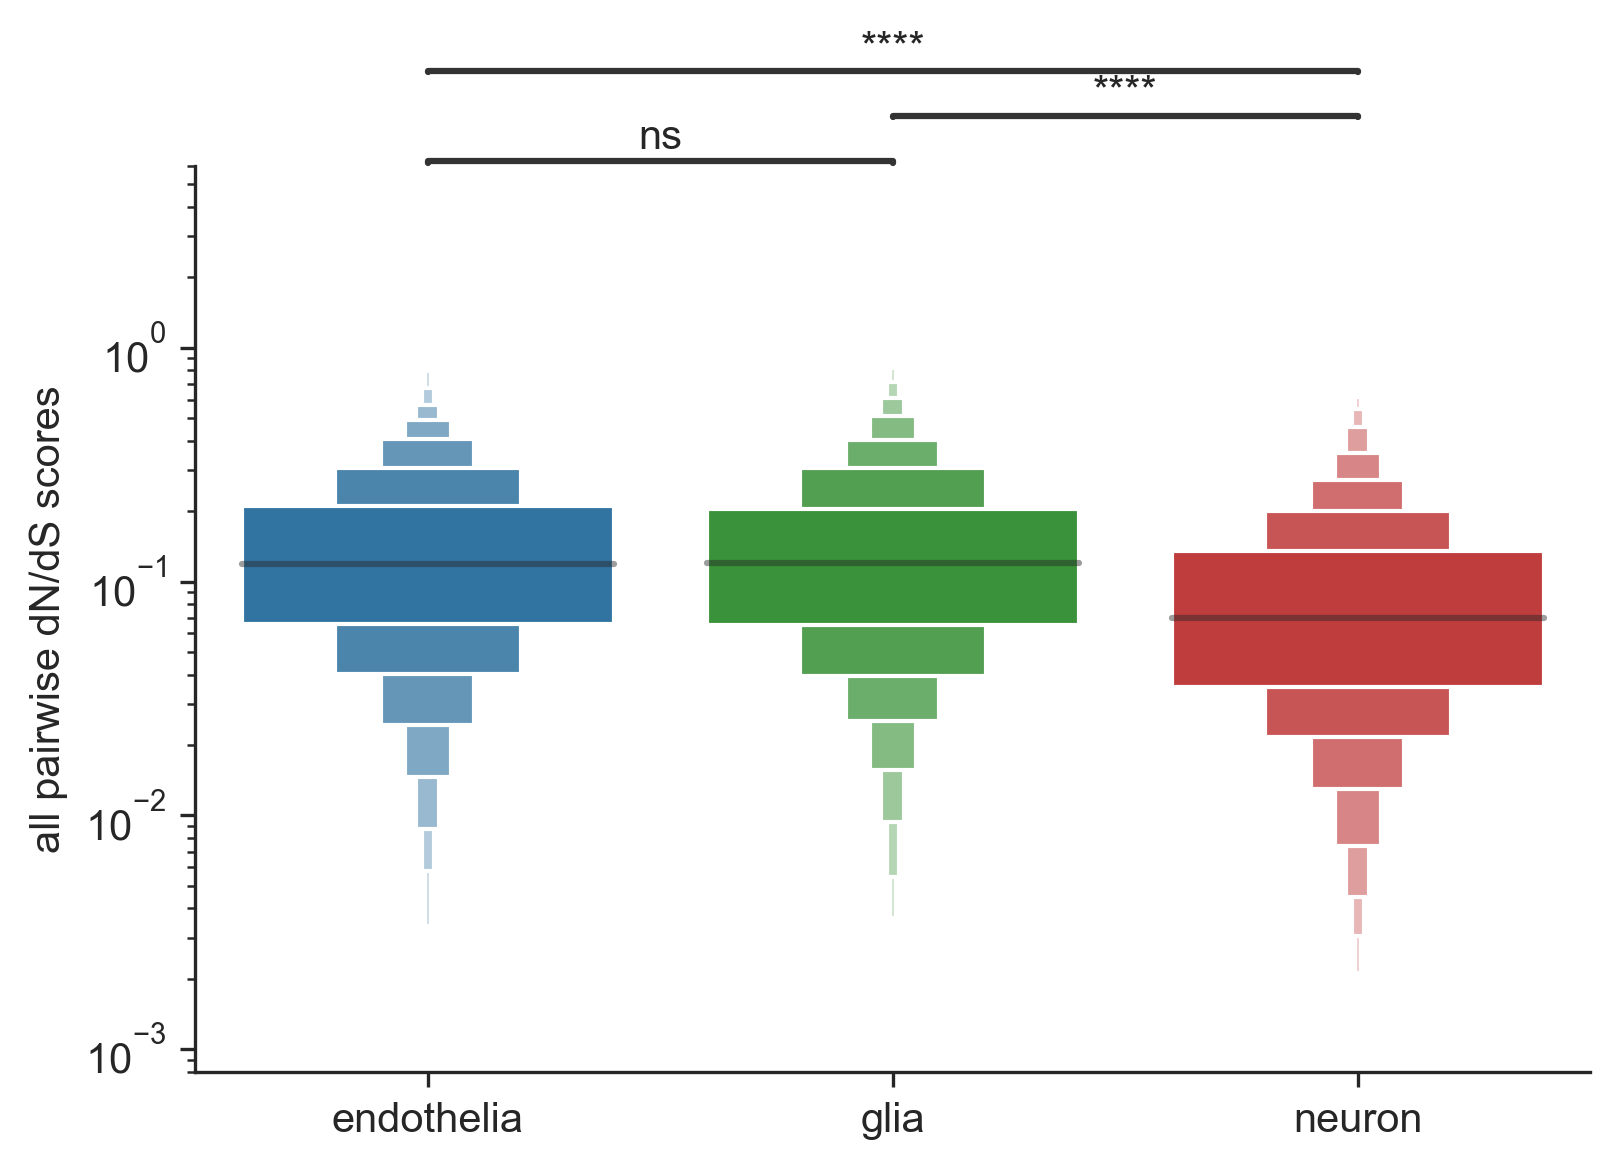

In [75]:
data=graph_df[graph_df['dNdS']!=0].reset_index()
data=data[data['Celltype'].isin(['neuron','endothelia','glia'])]
data=data[data['SpeciesCommonName']!='average']

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set(yscale='log')
ax.set_ylim(0.0008,6)

ax=sns.boxenplot(x='Celltype',y='dNdS',data=data,palette=palette,showfliers=False,outlier_prop=0,order=['endothelia','glia','neuron'])
ax.set(ylabel='all pairwise dN/dS scores',xlabel='')
sns.despine()
# conservative p value threshold for significance set at 0.0001, i.e., 1e-4
stats = add_stat_annotation(ax=ax,data=data,x="Celltype", y="dNdS",order=['endothelia','glia','neuron'],
                        box_pairs=[("endothelia", "glia"),
                                   ("endothelia", "neuron"),
                                   ("glia","neuron")],
                        test='Mann-Whitney', text_format='star',
                        comparisons_correction=None,
                        pvalue_thresholds=[[1e-7, "****"], [1e-6, "***"], [1e-5, "**"], [1e-4, "*"], [1, "ns"]],
                        loc='outside', verbose=2)
# plt.autoscale()
plt.savefig('../figures/MannWhitney/mouse_reference_genome/all_92species_conservative.svg')
plt.show()

[None]

(0.0008, 6)

[Text(0, 0.5, 'all pairwise dN/dS scores'), Text(0.5, 0, '')]

endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided, P_val=3.340e-01 U_stat=2.479e+09
glia v.s. neuron: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=4.510e+09
endothelia v.s. neuron: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=3.478e+09


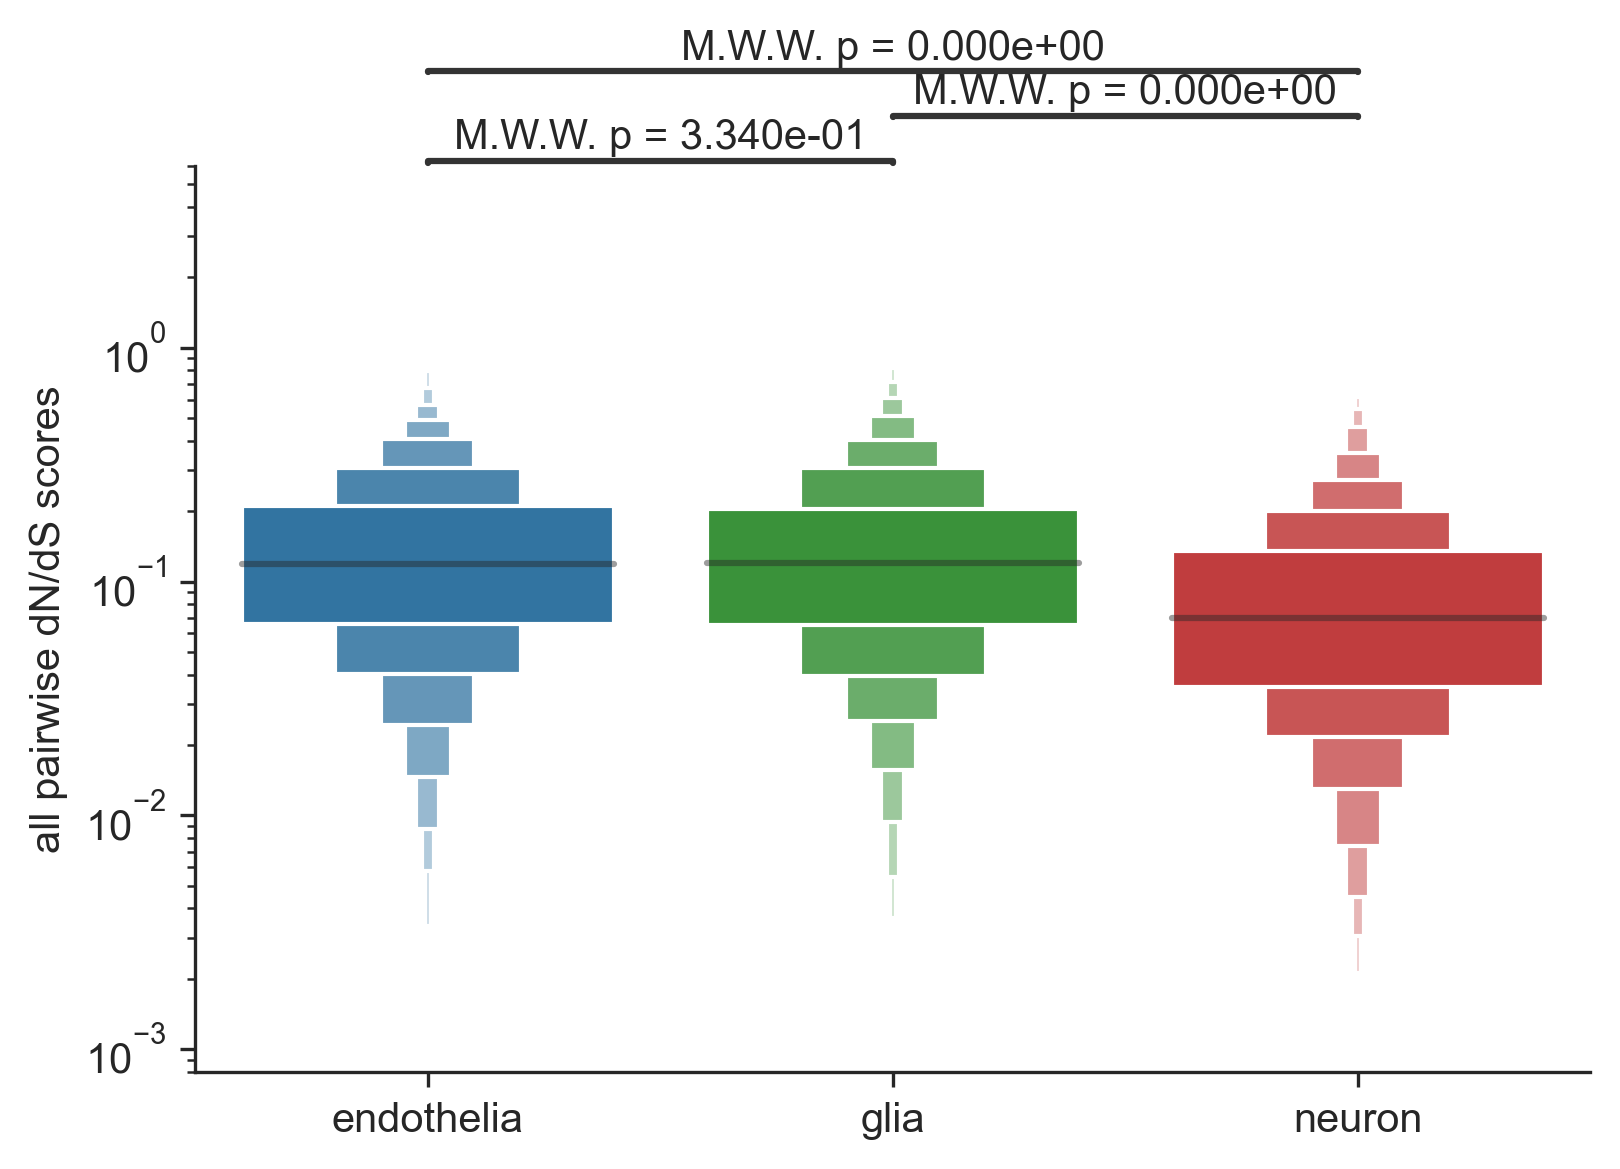

In [57]:
data=graph_df[graph_df['dNdS']!=0].reset_index()
data=data[data['Celltype'].isin(['neuron','endothelia','glia'])]
data=data[data['SpeciesCommonName']!='average']

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set(yscale='log')
ax.set_ylim(0.0008,6)

ax=sns.boxenplot(x='Celltype',y='dNdS',data=data,palette=palette,showfliers=False,outlier_prop=0,order=['endothelia','glia','neuron'])
ax.set(ylabel='all pairwise dN/dS scores',xlabel='')
sns.despine()
# conservative p value threshold for significance set at 0.0001, i.e., 1e-4
stats = add_stat_annotation(ax=ax,data=data,x="Celltype", y="dNdS",order=['endothelia','glia','neuron'],
                        box_pairs=[("endothelia", "glia"),
                                   ("endothelia", "neuron"),
                                   ("glia","neuron")],
                        test='Mann-Whitney', text_format='full',
                        comparisons_correction=None,
                        loc='outside', verbose=2)
# plt.autoscale()
# plt.savefig('../figures/MannWhitney/mouse_reference_genome/all_92species_conservative.pdf')
plt.show()

### log transform dN/dS data and run t test

In [49]:
log_data=data.copy(deep=True)

In [50]:
log_data['log_dNdS']=np.log10(log_data['dNdS'])

In [54]:
log_data

,SpeciesCommonName,dNdS,Celltype,log_dNdS
0,Panda,0.210556,neuron,-0.676633
1,Panda,0.306745,neuron,-0.513222
2,Panda,0.252119,neuron,-0.598395
3,Panda,0.380407,neuron,-0.419752
4,Panda,0.131689,neuron,-0.880452
...,...,...,...,...
230307,Red fox,0.059611,glia,-1.224671
230308,Red fox,0.206826,glia,-0.684394
230309,Red fox,0.302362,glia,-0.519473
230310,Red fox,0.094507,glia,-1.024537


[Text(0, 0.5, 'all pairwise dN/dS scores'), Text(0.5, 0, '')]

p-value annotation legend:
ns: 1.00e-04 < p <= 1.00e+00
*: 1.00e-05 < p <= 1.00e-04
**: 1.00e-06 < p <= 1.00e-05
***: 1.00e-07 < p <= 1.00e-06
****: p <= 1.00e-07

endothelia v.s. glia: t-test independent samples, P_val=8.590e-01 stat=1.776e-01
glia v.s. neuron: t-test independent samples, P_val=0.000e+00 stat=1.077e+02
endothelia v.s. neuron: t-test independent samples, P_val=0.000e+00 stat=9.960e+01


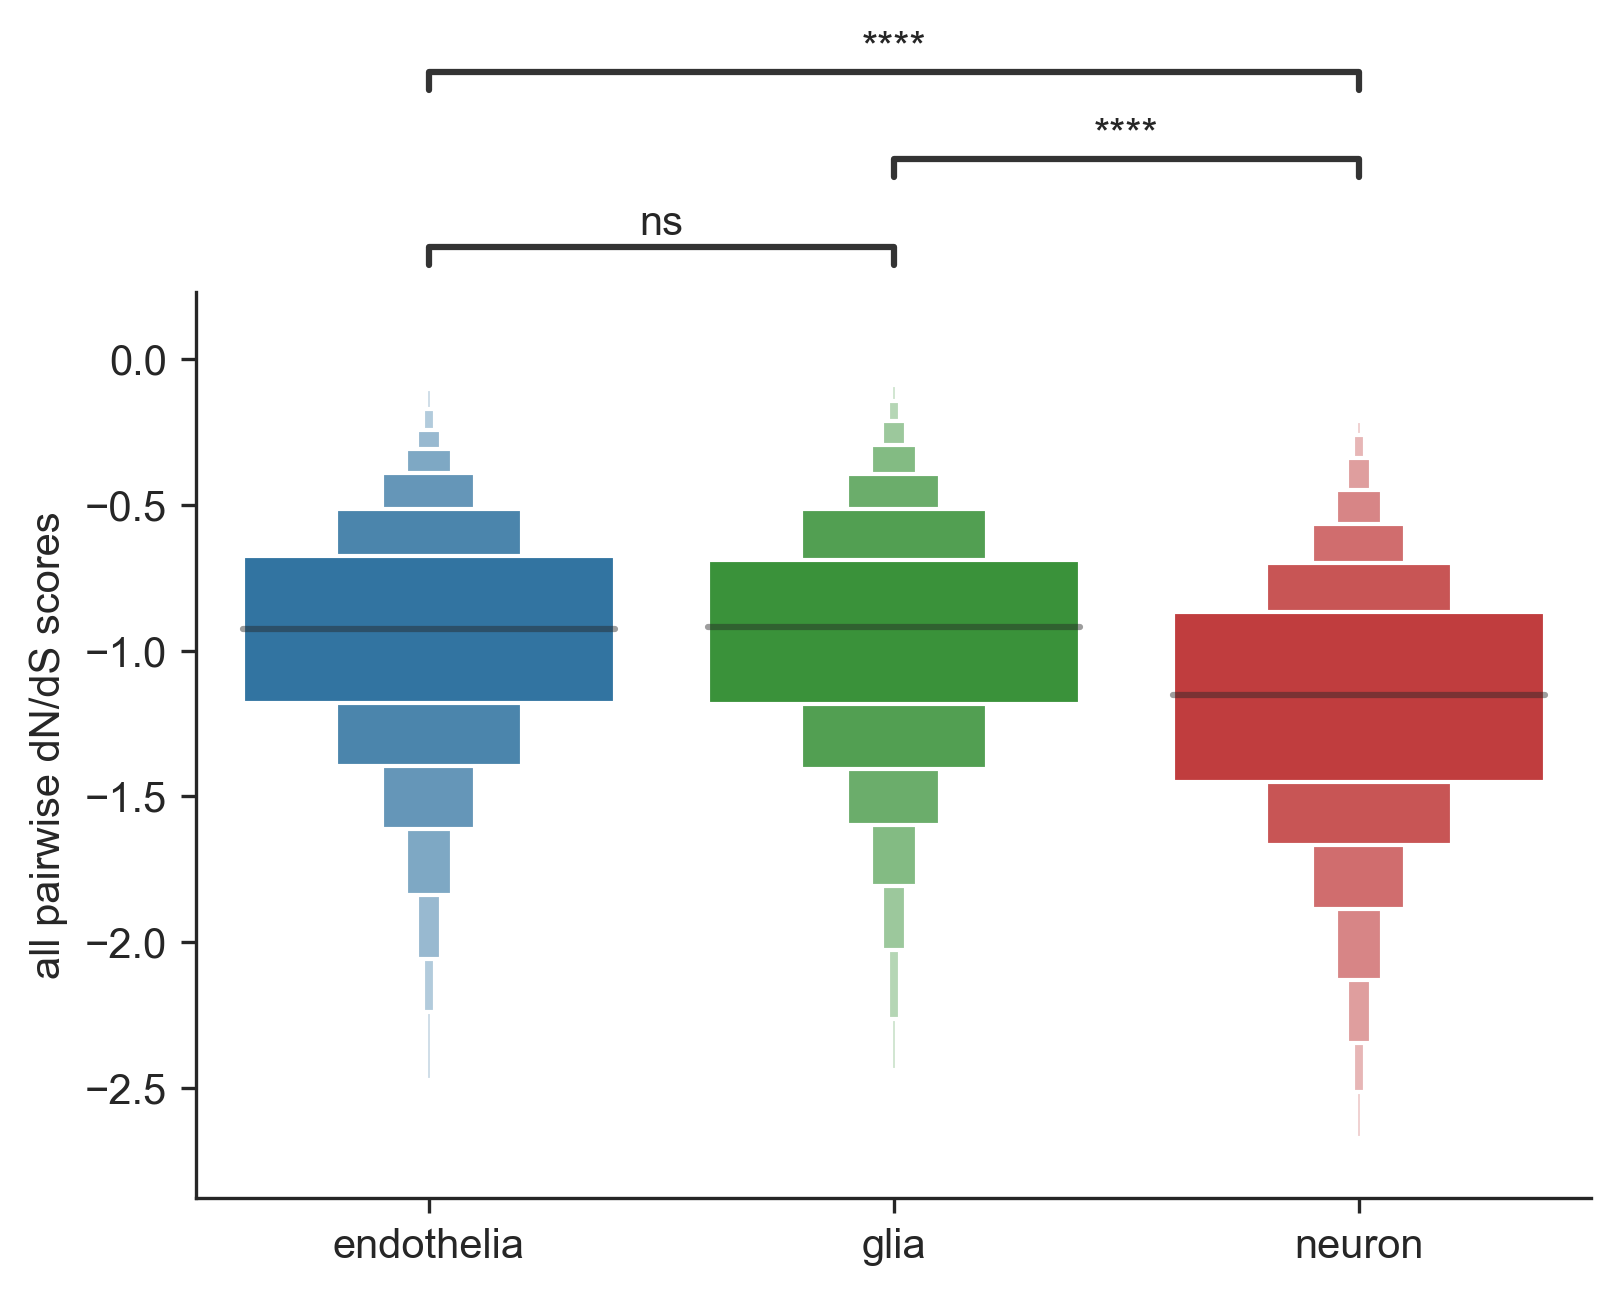

In [55]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.set(yscale='log')
# ax.set_ylim(0.0008,6)

ax=sns.boxenplot(x='Celltype',y='log_dNdS',data=log_data,palette=palette,showfliers=False,outlier_prop=0,order=['endothelia','glia','neuron'])
ax.set(ylabel='all pairwise dN/dS scores',xlabel='')
sns.despine()
# conservative p value threshold for significance set at 0.0001, i.e., 1e-4
stats = add_stat_annotation(ax=ax,data=log_data,x="Celltype", y="log_dNdS",order=['endothelia','glia','neuron'],
                        box_pairs=[("endothelia", "glia"),
                                   ("endothelia", "neuron"),
                                   ("glia","neuron")],
                        test='t-test_ind', text_format='star',
                        comparisons_correction=None,
                        pvalue_thresholds=[[1e-7, "****"], [1e-6, "***"], [1e-5, "**"], [1e-4, "*"], [1, "ns"]],
                        loc='outside', verbose=2)
# plt.autoscale()
plt.show()